In [1]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

# For which test case do we plot?
`swe` is the shallow water vortex, `euler` the Euler vortex and `rb` the rising bubble.

In [9]:
swe = True
euler = False
rb = False

# Initial distribution plotter

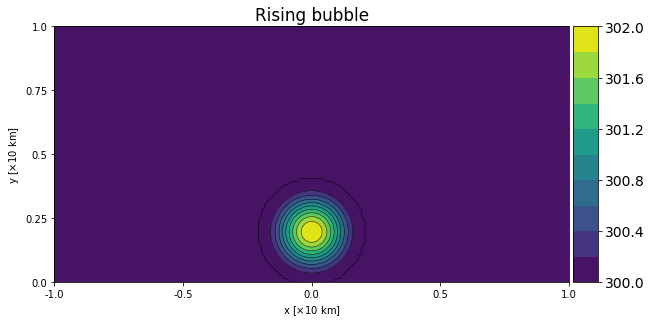

In [3]:
# initial time-step
times = [0]
l_typ = 'WINDOW_STEP'

def get_ens(tc, sfx , diff, attribute, swe=False):
    ens = tc.get_ensemble(times, 1, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag='ic')[0]
    if swe:
        ens = ens[:,0,:]

    # so unit of each contour is 10000 Pa for the Euler vortex, and 10m for the shallow water vortex
    ens *= 10.0 

    label = sfx + '_' + attribute
    return label, ens.T

diff = False
if swe:
    attribute = 'p2_nodes'
    et = 1.0
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    py_directory = "../../%s/" %directory

    Nx, Ny, Nz = 64, 1, 64
    swe_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    
    sfx1 = 'comp_bal_noib'
    l1, a1 = get_ens(swe_tc, sfx1, diff, attribute,swe=True)
    la = 'SWE vortex'
    aa = a1
    lvls = np.arange(-0.0155,0.0035,0.0030) * 10.0
    lbl = 'swe'
elif euler:
    attribute = 'p2_nodes'
    et = 1.0
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    py_directory = "../../%s/" %directory

    Nx, Ny = 64, 64
    euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'comp_bal_noib'
    l2, a2 = get_ens(euler_tc, sfx1, diff, attribute)
    la = 'Euler vortex'
    aa = a2
    lvls = np.arange(-0.0065,0.0015,0.0010) * 10.0
    lbl = 'euler'
elif rb:
    et = 10.0
    base_fn = "output_rising_bubble"
    directory = "output_rising_bubble"
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 160, 80
    rb_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'comp_imbal_half_CFLfixed_ib-0'
    _, a1 = get_ens(rb_tc, sfx1, diff, 'rho')
    _, a2 = get_ens(rb_tc, sfx1, diff, 'rhoY')
    la = 'Rising bubble'
    aa = a2/a1 * 300
    lvls = np.linspace(300.0,302.0,11)
    lbl = 'rb'
    
ll = [aa, la]
pl_lst = [ll]

pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
if swe or euler:
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
else:
    x_axs = [-1.0,-0.5,0.0,0.5,1.0]
    y_axs = [0.0,0.25,0.5,0.75,1.0]
    
if swe: 
    x_label = r'x [$\times 100$ m]'
    y_label = r'y [$\times 100$ m]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Nz-1,5)
else:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,5)


pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(aspect='equal',method='contour',lvls=lvls)

pl.save_fig('./output/initial_%s' %lbl)

# Truth plotter

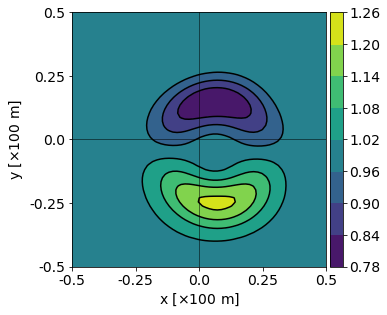

In [10]:
l_typ = 'TIME'

def get_ens(tc, times, sfx , diff, attribute, swe=False):
    ens = tc.get_ensemble(times, 1, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag='after_full_step')[1]
    if swe:
        ens = ens[:,0,:]
    else:
        # so unit of each contour is 10000 Pa for the Euler vortex
        ens *= 100.0 

    label = sfx + '_' + attribute
    return label, ens.T

diff = False
if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    py_directory = "../../%s/" %directory
    
    et = 3.0
    times = [3.0]
    attr = 'rhou'
    Nx, Ny, Nz = 64, 1, 64
    swe_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    
    sfx1 = 'truth_ib-0'
    l1, a1 = get_ens(swe_tc, times, sfx1, diff, attr,swe=True)
    la = 'SWE_vortex'
    aa = a1
    lbl = 'euler'
elif euler:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    py_directory = "../../%s/" %directory

    et = 3.0
    times = [3.0]
    attr = 'p2_nodes'
    Nx, Ny = 64, 64
    euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'truth_ib-0'
    l2, a2 = get_ens(euler_tc, times, sfx1, diff, attr)
    la = 'Euler vortex'
    aa = a2
    lvls = np.arange(-0.0065,0.0015,0.0010) * 100.0
    lbl = 'euler'
elif rb:
    base_fn = "output_rising_bubble"
    directory = "output_rising_bubble"
    py_directory = "../../%s/" %directory
    
    et = 10.0
    times = [10.0]
    attr = 'rhou'
    Nx, Ny = 160, 80
    rb_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'comp_imbal_half_CFLfixed_ib-0'
    _, a1 = get_ens(rb_tc, times, sfx1, diff, attr)
    la = 'Rising bubble'
    aa = a1
    lvls = np.linspace(300.0,302.0,11)
    lbl = 'rb'
    
ll = [aa, '']
pl_lst = [ll]

pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)

if swe: 
    x_label = r'x [$\times 100$ m]'
    y_label = r'y [$\times 100$ m]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Nz-1,5)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    axvline = 31.5
    axhline = 31.5
elif euler:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(0,Nx,5)
    y_loc = np.linspace(0,Ny,5)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    axvline = 32
    axhline = 32
elif rb:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,5) 
    x_axs = [-1.0,-0.5,0.0,0.5,1.0]
    y_axs = [0.0,0.25,0.5,0.75,1.0]
    
if rb:
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
else:
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline)
_ = pl.plot(aspect='equal',method='contour')

pl.save_fig('./output/%s_truth' %lbl)

# Observation plotter

For simulations with data assimilation, all data assimilation associated arrays are saved in the `.dat` file as pickled instances. This setting to output pickled data is toggled by the `da_debug` switch. The arrays are loaded (*unpickled*) in order.

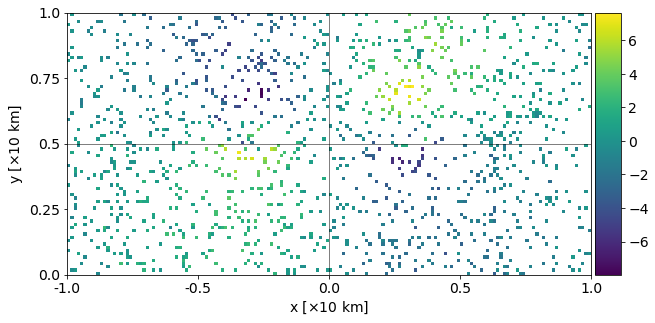

In [5]:
if swe:
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0
    base_fn = 'output_swe_vortex'
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
elif euler:
    Nx, Ny = 64, 64
    et = 3.0
    base_fn = 'output_travelling_vortex'
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
elif rb:
    Nx, Ny = 160, 80
    et = 10.0
    base_fn = 'output_rising_bubble'
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)

tags = tc.get_tag_dict()

N = 10
if swe:
    sfx0 = 'wdawloc_rhou_rhow_wda_ib-0'
    p_ref = 1.0 # unit of contours in [m]
    lbl = 'swe'
elif euler:
    sfx0 = 'wdawloc_all_wda_ib-0'
    p_ref = 1e+2 # unit of contours in [kPa]
    lbl = 'euler'
elif rb:
    sfx0 = 'wdawloc_rhou_rhov_wda_CFLfixed_ib-0'
    p_ref = 8.61 * 1e1 # unit of contours in [kPa]
    lbl = 'rb'
sfx0 = tc.cb_suffix(1,0, '%s' %(sfx0))

fn_pickle = tc.get_filename(N,sfx0,format='dat')
path_pickle = tc.get_path(fn_pickle)

i2 = (slice(2,-2),slice(2,-2))

file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
obs = pickle.load(file)
obs_noisy = pickle.load(file)
obs_mask = pickle.load(file)
obs_covar = pickle.load(file)
file.close()

if swe or rb:
    attr = 'rhou'
elif euler:
    attr = 'p2_nodes'

if swe or euler:
    time_index = 11 # last observation time
elif rb:
    time_index = 10 # last observation time

attribute = attr
obs_arr = obs[time_index][attribute][i2].T
obs_arr = [obs_arr, 'observation']
obs_n_arr = obs_noisy[time_index][attribute][i2].T
obs_mask_arr = obs_mask[time_index][attribute]
obs_mask_arr = obs_mask_arr[i2].T
obs_noisy_masked = np.ma.array(obs_n_arr,mask=obs_mask_arr).filled(fill_value=np.nan)
pl_lst = [[obs_noisy_masked * p_ref,'']]

pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)

if swe: 
    x_label = r'x [$\times 100$ m]'
    y_label = r'y [$\times 100$ m]'
    x_loc = np.linspace(-0.5,Nx-0.5,5)
    y_loc = np.linspace(-0.5,Nz-0.5,5)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    axvline = 31.5
    axhline = 31.5
elif euler:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(-0.5,Nx+0.5,5)
    y_loc = np.linspace(-0.5,Ny+0.5,5)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    axvline = 32
    axhline = 32
elif rb:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(-0.5,Nx-0.5,5)
    y_loc = np.linspace(-0.5,Ny-0.5,5)
    x_axs = [-1.0,-0.5,0.0,0.5,1.0]
    y_axs = [0.0,0.25,0.5,0.75,1.0]
    axvline = 79.5
    axhline = 39.5

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline)
_ = pl.plot(aspect='equal',method='imshow')

pl.save_fig('./output/obs_%s_%s' %(lbl,attr))